# Pyrocko Notebook
## Double Couple Waveform Inversion (The 2009 Aquila Earthquake)

In this Jupyter-notebook we look at teleseismic waveforms of the 2009 Aquila Earthquake and setup `pyrocko.gf` forward modelling to invert for the double couple mechanism and full moment tensor of the event. We will use `pyrocko` (https://pyrocko.org/docs/current/index.html) to handle the seismic data and execute the forward modelling based on pre-calculated Green's function stores, `scipy` delivers the optimisation algorithms.
Besides this Notebook you will also need to download the utils_nb.py file from this repository.

An interactive presentation of the pyrocko package can be found here:
https://data.pyrocko.org/presentations/pyrocko-workshop-dgg-2021/



_Authors:_
Andreas Steinberg, Marius Isken

-edited May 2025 



Scheme of components which can be used in the pyrocko framework for inversions (not all of them are used in this notebook)
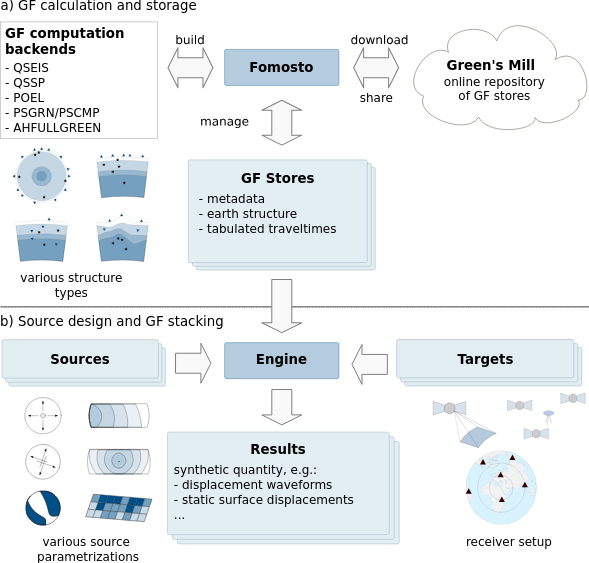

Lets import some functions:

In [10]:
%matplotlib inline
# Cell 1
import time
import os
import scipy
import numpy as num
import matplotlib.pyplot as plt
from collections import OrderedDict
import obspy
from pyrocko import obspy_compat
obspy_compat.plant()

# import helper functions
import utils_nb

# import functions from pyrocko directly for utility
from pyrocko import gf, trace
from pyrocko import moment_tensor as mtm
from pyrocko.gf import ws, LocalEngine, Target, DCSource
from pyrocko import util, pile, model, config, trace, io, pile, catalog

km = 1000.

In [11]:
import pyrocko
import numpy as np
np.version.__version__
#pyrocko.version



'1.24.3'

### Get GlobalCMT Start Model
We use the GlobalCMT catalog to search for the 2009 Aquila Earthquake and initalize a source for the starting model.

In [12]:
# Cell 2
tmin = util.str_to_time('2009-04-06 00:00:00')  # beginning time of query
tmax = util.str_to_time('2009-04-06 05:59:59')  # ending time of query
event = catalog.GlobalCMT().get_events(
    time_range=(tmin, tmax),
    magmin=6.)[0]

print(event)

base_source = gf.MTSource.from_pyrocko_event(event)

--- !pf.Event
lat: 42.29
lon: 13.35
time: '2009-04-06 01:32:49.190000057'
depth: 12000.0
name: '200904060132A'
magnitude: 6.343080192483292
region: 'CENTRAL ITALY'
catalog: 'gCMT'
moment_tensor: !pf.MomentTensor
  mnn: 1.43e+18
  mee: 1.87e+18
  mdd: -3.3e+18
  mne: 1.77e+18
  mnd: -1.43e+18
  med: 2.6900000000000003e+17
  strike1: 120.23408298515041
  dip1: 54.24086908958049
  rake1: -112.81739742081386
  strike2: 335.98575923255856
  dip2: 41.58440373860804
  rake2: -61.69749587601104
  moment: 3.6696131948749036e+18
  magnitude: 6.343080192483292
duration: 7.0



### Initialize Forward Modelling Engine (Seismosizer)
We download the precalculated Green's function database (`Store`) *global_2s_25km* from http://kinherd.org

The 

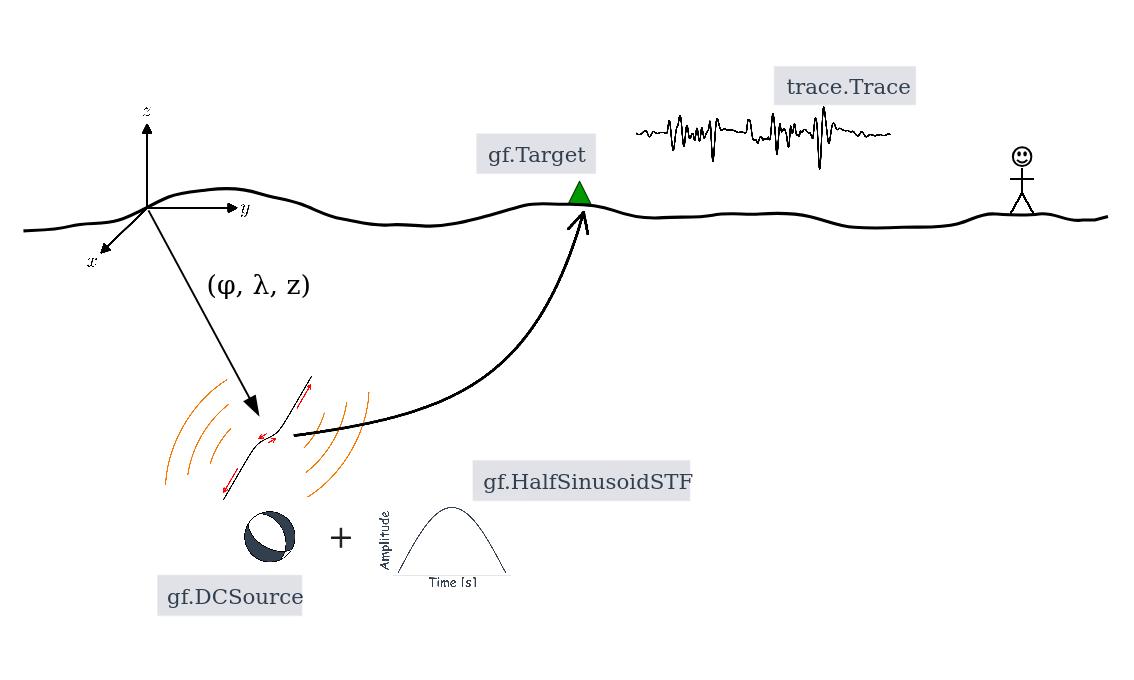

In [13]:
# Cell 3
store_id = 'global_2s_25km'
if not os.path.exists(store_id):
    ws.download_gf_store(site='kinherd', store_id=store_id)
    
# if download did not work: 
#os.system("unzip global_2s_v2_25km.zip")

Now we fire up the `engine` to forward model synthetic seismograms on our _global_2s_25km_ GF database.

In [14]:
# Cell 4
engine = gf.LocalEngine(store_superdirs=['.']) # The Path to where the gf_store(s)
store = engine.get_store(store_id)  # Load the store.

Let's use our source, stf and store to calculate a synthetic waveform:

In [ ]:
# Cell 5
# Global CMT solution for L'Aquila event
dc_source = gf.DCSource(
    lat=42.29, lon=13.35, depth=12*km, magnitude=6.3,
    time=util.str_to_time('2009-04-06 01:32:49.190'),
    strike=336.0, dip=42.0, rake=-62.0)
# Source-time function
laquila_stf = gf.TriangularSTF(duration=1.0)
# Update the Source with the choosen STF
dc_source.stf = laquila_stf
 
# Modelling targets (seismometer at BFO)
waveform_targets = []
for channel_code in ('BHE', 'BHN', 'BHZ'):
    target = gf.Target(
        lat=48.3301, lon=8.3296, elevation=638.0,
        codes=('II', 'BFO', '00', channel_code),
        quantity='velocity', store_id=store_id)
 
    waveform_targets.append(target)

    
response = engine.process(dc_source, waveform_targets)

syn_velocity_traces = response.pyrocko_traces()

# View synthetic seismograms
trace.snuffle(
    syn_velocity_traces, events=[dc_source.pyrocko_event()],
    stations=[x.pyrocko_station() for x in waveform_targets])

cc.py:pyrocko.gui.snuffling.okada - WARNING  - 
 /home/asteinbe/.snufflings/okada/libokada.so: cannot open shared object file: No such file or directory
--> run 'make' in okada snuffling directory <--


### Load the Waveforms
We download the instrument-corrected seismic waveforms and use a `pyrocko.pile` to manage the data.

In [1]:
# Cell 6
# Download the instrument-corrected 2009 Aquila Earthquake data
data_path = utils_nb.download_dir('aquila_realdata/')
data = pile.make_pile([data_path])

obspy_stream = obspy_compat.to_obspy_stream(data) # Conversion to obspy stream. Not needed here, just for your convience
traces = data.all()  # retrieves the raw waveform data as a 2D `numpy.array`.
f_low = 0.1  # Hz, for a lowpass filter

for tr in traces:
    tr.lowpass(4, f_low)
    

NameError: name 'utils_nb' is not defined

### Optimisation Parameters
Setup of the optimisation parameters, as well as boundaries for the source parameters.

In [ ]:
# Cell 7
component = 'Z'
taper = trace.CosFader(xfade=2.0)  # Cosine taper, 2s fade

phase = 'P' # Phase to fit
tmin_fit = 15. # [s] to fit before synthetic phase onset (from GFStore)
tmax_fit = 25. # [s] ... after

# Bounds of the inversion parameters for a DC source
bounds = OrderedDict([
    ('north_shift', (-20.*km, 20.*km)),
    ('east_shift', (-20.*km, 20.*km)),
    ('depth', (0.5*km, 14.*km)),
    ('magnitude', (6.2, 6.4)),
    ('strike', (0., 360.)),
    ('dip', (0., 90.)),
    ('rake', (-180, 180.)),
    ('timeshift', (-6.5, 2.)),
    ])


# # Bounds of the inversion parameters for a full MT source
bounds_MT = OrderedDict([
    ('north_shift', (-20.*km, 20.*km)),
    ('east_shift', (-20.*km, 20.*km)),
    ('depth', (0.5*km, 14.*km)),
    ('mnn', (-1e19, 1e19)),
    ('mee', (-1e19, 1e19)),
    ('mdd', (-1e19, 1e19)),
    ('mne', (-1e19, 1e19)),
    ('mnd', (-1e19, 1e19)),
    ('med', (-1e19, 1e19)),
    ('timeshift', (-6.5, 2.)),
    ])

### Station and _Target_ Setup
We use the term _Target_ for a single component of a single station.

In [ ]:
# Cell 8
stations_list = model.load_stations('data/aquila_realdata/stations_short.txt')
for s in stations_list:
    s.set_channels_by_name(*component.split())

Next we define the `Target` - where to calculate the synthetic seismogram.

In [ ]:
# Cell 9
targets=[]
for s in stations_list:
    target = Target(
            lat=s.lat,
            lon=s.lon,
            store_id=store_id,   # The gf-store to be used for this target,
            interpolation='multilinear',  # Interpolation method between GFStore nodes
            quantity='displacement',
            codes=s.nsl() + ('BH' + component,))
    targets.append(target)

### Objective Function
Now the objective function that will be called by `scipy.optimize`:

In [ ]:
# Cell 10
source = gf.DCSource(
    lat=event.lat,
    lon=event.lon)


sourceMT = gf.MTSource(
    lat=event.lat,
    lon=event.lon)

laquila_stf = gf.TriangularSTF(duration=10.0)

sourceMT.stf = laquila_stf
# Task: Update the source inversion with a realistic stf, e.g.: dc_source.stf = laquila_stf

def update_mtsource(params):
    s = sourceMT
    s.north_shift = float(params[0])
    s.east_shift = float(params[1])
    s.depth = float(params[2])
    s.mnn = float(params[3])
    s.mee = float(params[4])
    s.mdd = float(params[5])
    s.mne = float(params[6])
    s.mnd = float(params[7])
    s.med = float(params[8])
    s.time = float(event.time - params[9])
    return sourceMT

def update_source(params):
    s = source
    s.north_shift = float(params[0])
    s.east_shift = float(params[1])
    s.depth = float(params[2])
    s.magnitude = float(params[3])
    s.strike = float(params[4])
    s.dip = float(params[5])
    s.rake = float(params[6])
    s.time = float(event.time - params[7])
    return source

def process_trace(trace, tmin, tmax, lowpass=False, inplace=True):
    if lowpass:
        trace.lowpass(4, f_low)
    trace = trace.chop(tmin, tmax, inplace=inplace)
    trace.taper(taper)
    return trace

iiter = 0


def trace_fit(params, line=None, MTsource=False):
    global iiter
    if MTsource == True:
        update_mtsource(params)
    else:
        update_source(params)

    # Forward model synthetic seismograms
    if MTsource == True:
        response = engine.process(sourceMT, targets)
    else:
        response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()

    misfits = 0.
    norms = 0.

    for obs, syn, target in zip(traces, syn_traces, targets):
        syn_phs = store.t(phase, base_source, target)
        
        tmin = base_source.time + syn_phs - tmin_fit  # start before theor. arrival
        tmax = base_source.time + syn_phs + tmax_fit  # end after theor. arrival
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=True)

        misfits += num.sqrt(num.sum((obs.ydata - syn.ydata)**2))
        norms += num.sqrt(num.sum(obs.ydata**2))
    
    misfit = num.sqrt(misfits**2 / norms**2)
    
    iiter += 1

    if line:
        data = {
            'y': [misfit],
            'x': [iiter],
        }
        line.data_source.stream(data)

    return misfit

#### Running the optimization and plotting of the Convergence
For plotting we use bokeh (which you might need to install: `pip3 install bokeh`)  
Jupyter Lab also requires the Bokeh extension: `jupyter labextension install jupyterlab_bokeh`  
More info at https://bokeh.pydata.org/en/latest/docs/user_guide/notebook.html

In [1]:
# Cell 11
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

f = figure(title='SciPy Optimisation Progress',
           x_axis_label='# Iteration',
           y_axis_label='Misfit')
plot = f.scatter([], [])
show(f, notebook_handle=True)

Loading BokehJS ...

### Optimisation with SciPy
We will use `scipy.optimize.differential_evolution` to find a best fitting model. The method is stochastic in nature (does not use gradient methods) to find the minimium, and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient based techniques. The scipy solver can easily be exchanged for a method of your favor. If you just want a quick demonstration, you can change the number of maxiter in the solve function to something lower.

In [ ]:
# Cell 12
# Solve for a DC source
MTsource = False
def solve():
    t = time.time()
    result = scipy.optimize.differential_evolution(
        trace_fit,
        args=[plot, MTsource],
        bounds=tuple(bounds.values()),
        maxiter=1500000,
        tol=0.0001,
        callback=lambda a, convergence: push_notebook())

    source = update_source(result.x)
   # source.regularize()

    print("Time elapsed: %.1f s" % (time.time() - t))
    print("Best model:\n - Misfit %f" % trace_fit(result.x))
    print(source)
    return result, source


# Start the optimisation
result, best_source = solve()
dcsource = update_source(result.x)

Alternatively we can invert for a full Moment Tensor: 

In [ ]:
# Cell 13
# Solve for a full MT source
MTsource = True
def solve():
    t = time.time()
    result = scipy.optimize.differential_evolution(
        trace_fit,
        args=[plot, MTsource],
        bounds=tuple(bounds_MT.values()),
        maxiter=1500000,
        tol=0.0001,
        callback=lambda a, convergence: push_notebook())

    mtsource = update_mtsource(result.x)

    print("Time elapsed: %.1f s" % (time.time() - t))
 #   print("Best model:\n - Misfit %f" % trace_fit(result.x, MTsource))
    print(mtsource)
    return result, mtsource


# Start the optimisation
result_mt_source, best_source_mt = solve()
mtsource = update_mtsource(result_mt_source.x)

Compare with: https://earthquake.usgs.gov/earthquakes/eventpage/usp000gvtu/moment-tensor

### Plot the Results
Now we plot the synthetic waveforms produced by our the best model vs. the observed traces.

In [ ]:
# Cell 14
def plot_traces(result, MTsource=False):
    nstations = len(stations_list)
    if MTsource == True:
        response = engine.process(mtsource, targets)
    else:
        response = engine.process(source, targets)
    
    syn_traces = response.pyrocko_traces()

    fig, axes = plt.subplots(nstations, squeeze=True, sharex=True, figsize=(20,20))
    fig.subplots_adjust(hspace=0)
    plt.setp([ax.get_xticklabels() for ax in axes[:-1]], visible=False)

    for istation, (obs, syn, target) in enumerate(zip(traces, syn_traces, targets)):
        ax = axes[istation]
        tp = store.t(phase, base_source, target)
        tp_onset = base_source.time + tp
        tmin = tp_onset - tmin_fit
        tmax = tp_onset + tmax_fit
        
        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)
        
        s1 = ax.plot(obs.get_xdata(), obs.ydata, color='b')
        s2 = ax.plot(syn.get_xdata(), syn.ydata, color='r')
        s3 = ax.plot([tp_onset, tp_onset], [tr.ydata.min(), tr.ydata.max()], 'k-', lw=2)

        ax.text(-.2, 0.5, stations_list[istation].station,
                transform=ax.transAxes)
        ax.set_yticklabels([], visible=False)

    axes[-1].set_xlabel('Time [s]')
    plt.suptitle('Waveform fits for %s-Phase and component %s' % (phase, component))
    plt.legend(
        (s1[0], s2[0], s3[0]),
        ('Data', 'Synthetic','%s Phase-onset' % phase),
        loc='upper center',
        bbox_to_anchor=(0.5, -2.),
        fancybox=True, shadow=True, ncol=5)
    
    plt.show()
MTsource = False

plot_traces(result, MTsource)

Alternatively we can look at the waveforms interactivly with snuffler: 

In [ ]:
# Cell 15
def plot_snuffler(result, source):
    engine = gf.get_engine(["."])
    response = engine.process(source, targets)
    syn_traces = response.pyrocko_traces()
    obs_traces = []
    
    for obs, syn, target in zip(traces, syn_traces, targets):
        tp = store.t('P', base_source, target)
        tmin = base_source.time + tp - tmin_fit
        tmax = base_source.time + tp + tmax_fit

        syn = process_trace(syn, tmin, tmax)
        obs = process_trace(obs, tmin, tmax, lowpass=False, inplace=False)

        obs_traces.append(obs)

    trace.snuffle(obs_traces + syn_traces, stations=stations_list, events= [event])
plot_snuffler(result, best_source)

Plot the resulting source mechanism and the piercing points of the stations used in the inversion.

In [ ]:
# Cell 16
from pyrocko import moment_tensor as pmt, cake, orthodrome
from pyrocko.plot import beachball

size = 1
offset = 2.1

def plot_source_result_piercing_points(source, stations_list, store):
    # source position and mechanism
    slat, slon, sdepth = source.lat, source.lon, source.depth        
    mt = source.pyrocko_moment_tensor()

    # receiver positions
    rdepth = 0.0
    rlatlons = []
    for station in stations_list:
        rlatlons.append((station.lat, station.lon))

    # earth model and phase for takeoff angle computations

    store = engine.get_store(store_id)
    mod = store.config.earthmodel_1d
    phases = cake.PhaseDef.classic('P')
    
    # setup figure with aspect=1.0/1.0, ranges=[-1.1, 1.1]
    fig = plt.figure(figsize=(10., 10.))  # size in inch
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
    axes = fig.add_subplot(1, 1, 1, aspect=1.0)
    axes.set_axis_off()
    axes.set_xlim(-1.1, 3.5)
    axes.set_ylim(-1.1, 1.1)

    projection = 'lambert'

    beachball.plot_beachball_mpl(
        mt, axes,
        position=(0., 0.),
        size=size,
        color_t=(0.7, 0.4, 0.4),
        projection=projection,
        size_units='data')

    for rlat, rlon in rlatlons:
        distance = orthodrome.distance_accurate50m(slat, slon, rlat, rlon)
        rays = mod.arrivals(
            phases=cake.PhaseDef('P'),
            zstart=sdepth, zstop=rdepth, distances=[distance*cake.m2d])

        if not rays:
            continue

        takeoff = rays[0].takeoff_angle()
        azi = orthodrome.azimuth(slat, slon, rlat, rlon)

        # to spherical coordinates, r, theta, phi in radians
        rtp = num.array([[size, num.deg2rad(takeoff), num.deg2rad(90.-azi)]])

        # to 3D coordinates (x, y, z)
        points = beachball.numpy_rtp2xyz(rtp)

        # project to 2D with same projection as used in beachball
        x, y = beachball.project(points, projection=projection).T
        axes.plot(x, y, 'X', ms=10., mew=2.0, mec='black', mfc='none')

plot_source_result_piercing_points(dcsource, stations_list, engine)



In [ ]:
# Cell 17
plot_source_result_piercing_points(mtsource, stations_list, engine)

Next we plot the station distribution with folium (which you might need to install)

In [ ]:
# Cell 18
def plot_stations():
    import folium
    fmap = folium.Map(
        location=[best_source.lat, best_source.lon],
        tiles='OpenStreetMap', attr="Laquila stations",
        zoom_start=1.5)
    folium.Marker([best_source.lat, best_source.lon],
        popup=('2009 Aquila Earthquake'),
        icon=folium.Icon(color='red', icon='info-sign')).add_to(fmap)
                  
    for s in stations_list:
        folium.Marker([s.lat, s.lon],
                      popup='<b>%s</b></h4>' % s.station).add_to(fmap)
    fmap.add_child(folium.LatLngPopup())
    return fmap
    
plot_stations()

Tasks:
  
1. Run the inversion again with a different, more realistic stf and explain why you used this. You can use ressources like the scardec catalog to obtain a STF estimate (http://scardec.projects.sismo.ipgp.fr/# and search for the date 2009-04-06). 
We already used a specific stf in block 5, L7. See also the comment on how to do this in Block 10. 

Available stfs in pyrocko are:     
    BoxcarSTF,
    TriangularSTF,
    HalfSinusoidSTF,
    ResonatorSTF,
    TremorSTF,
    SimpleLandslideSTF
See https://github.com/pyrocko/pyrocko/blob/deee904155f833bdea6c01a1937438f119803fb4/src/gf/seismosizer.py#L6227 for more details.

Compare the resulting moment tensor parameters with the one you obtained before.


2. How large is the percentage of isotropic, deviatoric and CLVD. Do you think the results are realistisc? How would this be different if this would not have been an earthquake but an explosion?

print(source.pyrocko_moment_tensor().standard_decomposition())

(moment_iso, ratio_iso, m_iso),
(moment_dc, ratio_dc, m_dc),
(moment_clvd, ratio_clvd, m_clvd),
(moment_devi, ratio_devi, m_devi),
(moment, 1.0, m)

3. What advantages does it have to use stations in the far-field? What source parameter can not be resoled?
        
print(mtsource.pyrocko_moment_tensor().moment)

print(mtsource.pyrocko_moment_tensor().deviatoric())
print(mtsource.pyrocko_moment_tensor().moment-mtsource.pyrocko_moment_tensor().deviatoric().moment)
print(mtsource.pyrocko_moment_tensor().deviatoric().moment/mtsource.pyrocko_moment_tensor().moment)


print(mtsource.pyrocko_moment_tensor().standard_decomposition())


print(source.pyrocko_moment_tensor().standard_decomposition())

print(mtm.kagan_angle(mtsource, source))


'''
Scaling relation used by Global CMT catalog for most of its events.
'''

mom = magnitude_to_moment(magnitudes)
(mom / 1.1e16)**(1./3.)